### Using NLP to Analyze Drug Reviews from Druglib.com

In [1]:
# https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29

In [2]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [3]:
# https://stackabuse.com/python-for-nlp-topic-modeling/

## Step by Step NLP Analysis

In [4]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [5]:
d_text = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
print(len(d_text))
d_text.head(4)

3107


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


### Text EDA

In [6]:
len(d_text)

3107

In [7]:
d_text.head(4)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


In [8]:
d_text['effectiveness'].value_counts()

Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: effectiveness, dtype: int64

In [9]:
d_text['sideEffects'].value_counts()

Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: sideEffects, dtype: int64

In [10]:
d_text['rating'].value_counts()

10    742
8     558
9     480
7     350
1     305
5     159
6     157
3     146
4     107
2     103
Name: rating, dtype: int64

In [11]:
d_text['condition'].value_counts()

depression                 236
acne                       165
anxiety                     63
insomnia                    54
birth control               49
                          ... 
acne and sun damage          1
anti-inflammatory/pain       1
high lpa                     1
severe hives angiodema       1
dark skin spots on face      1
Name: condition, Length: 1426, dtype: int64

In [12]:
d_text['benefitsReview']

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

In [13]:
review = d_text['benefitsReview']
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

### Text Formatting

#### Tokenizing

Do this for each Review column

In [14]:
tokenized_review = review.apply(nltk.word_tokenize)
tokenized_review.head(3)

0    [slowed, the, progression, of, left, ventricul...
1    [Although, this, type, of, birth, control, has...
2    [I, was, used, to, having, cramps, so, badly, ...
Name: benefitsReview, dtype: object

In [15]:
print(tokenized_review)

0       [slowed, the, progression, of, left, ventricul...
1       [Although, this, type, of, birth, control, has...
2       [I, was, used, to, having, cramps, so, badly, ...
3       [The, acid, reflux, went, away, for, a, few, m...
4       [I, think, that, the, Lyrica, was, starting, t...
                              ...                        
3102    [Increased, focus, ,, attention, ,, productivi...
3103    [Emotions, were, somewhat, blunted, ., Less, m...
3104                                              [--, -]
3105          [Controlled, complex, partial, seizures, .]
3106    [The, drug, Micardis, did, seem, to, alleviate...
Name: benefitsReview, Length: 3107, dtype: object


In [16]:
total_words = []
for sentence in tokenized_review:
    for word in sentence:
        total_words.append(word)

In [17]:
fdist = FreqDist(total_words)
print(fdist)

<FreqDist with 9540 samples and 126845 outcomes>


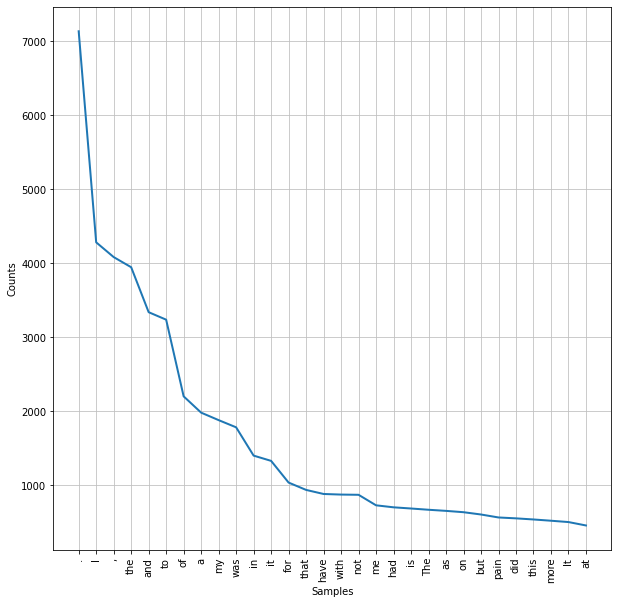

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
plt.figure(figsize=(10,10))
fdist.plot(30)

#### Removing Stop Words

In [19]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'your', 'off', 'you', 'his', 'an', "couldn't", "needn't", 'been', "didn't", "shouldn't", "weren't", 'y', "aren't", 'my', 'himself', 'our', 'didn', 'as', 'having', 'from', 'further', 'few', 'aren', 'up', 'which', 'needn', 'hers', 'because', 'couldn', 'other', "isn't", "won't", 'after', 'some', 'don', 'ma', "mustn't", 'very', 'why', 'about', "hadn't", 'herself', 'are', 'their', 'before', 'he', 'for', 'own', 'me', 'only', 'mightn', 'so', "she's", 'yours', 'o', 'until', 'shouldn', "should've", 'ain', 'or', 'those', "hasn't", 'we', 'while', 'did', 'haven', 'do', 'again', 'both', 'most', 'itself', 's', 'd', 'who', 'being', 'what', 'same', 'on', 'the', "you'd", 'at', 'any', 'whom', 'has', 'doesn', 'll', 'wasn', 'should', 'down', 'its', "wouldn't", 'i', 'out', 'just', 'to', 'am', 'have', 'will', 'her', 'each', 'ours', 'through', 'them', 'be', 'does', 'by', 'shan', "wasn't", 'weren', 'had', "doesn't", 're', 'won', 'all', 'is', "it's", 'myself', 'ourselves', 'nor', 'hasn', 'theirs', 'above', 'w

In [20]:
filtered_review=[]
for w in total_words:
    if w not in stop_words:
        filtered_review.append(w)
print("Filterd Words:",filtered_review[:20])

Filterd Words: ['slowed', 'progression', 'left', 'ventricular', 'dysfunction', 'overt', 'heart', 'failure', 'alone', 'agents', 'managment', 'hypertension', 'mangagement', 'congestive', 'heart', 'failur', 'Although', 'type', 'birth', 'control']


In [21]:
print(len(total_words))
print(len(filtered_review))

126845
82365


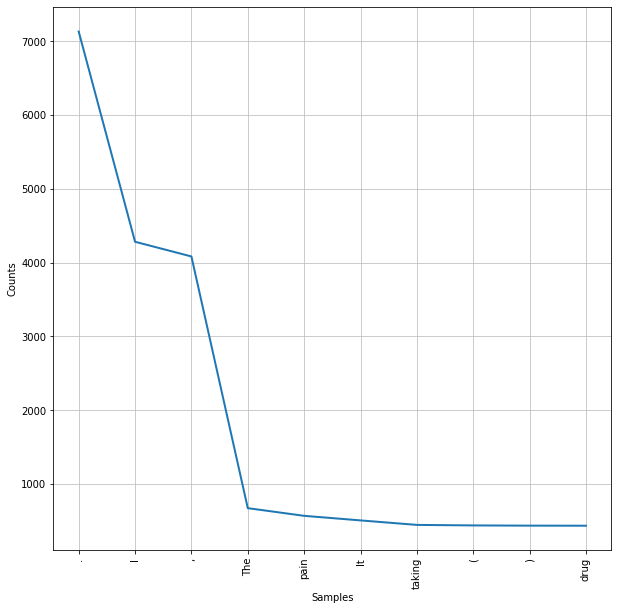

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [22]:
fdist = FreqDist(filtered_review)
plt.figure(figsize=(10,10))
fdist.plot(10)

Why are words like The, It, -, (, ) appearing above?

#### Stemming

In [23]:
ps = PorterStemmer()

stemmed_review=[]
for w in filtered_review:
    stemmed_review.append(ps.stem(w))

# print(stemmed_review)

['slow', 'progress', 'left', 'ventricular', 'dysfunct', 'overt', 'heart', 'failur', 'alon', 'agent', 'manag', 'hypertens', 'mangag', 'congest', 'heart', 'failur', 'although', 'type', 'birth', 'control', 'con', 'pro', ',', 'help', 'cramp', '.', 'It', "'s", 'also', 'effect', 'prevent', 'pregnanc', '.', '(', 'along', 'use', 'condom', 'well', ')', 'I', 'use', 'cramp', 'badli', 'would', 'leav', 'ball', 'bed', 'least', '2', 'day', '.', 'the', 'ponstel', "n't", 'take', 'pain', 'away', 'complet', ',', 'take', 'edg', 'much', 'normal', 'activ', 'possibl', '.', 'definit', 'miracl', 'medic', '!', '!', 'the', 'acid', 'reflux', 'went', 'away', 'month', 'day', 'drug', '.', 'the', 'heartburn', 'start', 'soon', 'I', 'stop', 'take', '.', 'So', 'I', 'began', 'treatment', '.', '6', 'month', 'pass', 'I', 'stop', 'take', '.', 'the', 'heartburn', 'came', 'back', ',', 'seem', 'wors', 'even', '.', 'the', 'doctor', 'said', 'I', 'tri', 'anoth', '6', 'month', 'treatment', '.', 'I', ',', 'exact', 'thing', 'happen'

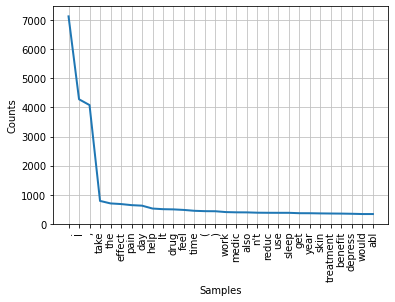

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
fdist = FreqDist(stemmed_review)
fdist.plot(30)

#### Lemmatiziation

In [25]:
lemmatizer = WordNetLemmatizer() 

In [26]:
print("movies:", lemmatizer.lemmatize("movies")) 
print("collecting:", lemmatizer.lemmatize("collecting")) 
print("collection:", lemmatizer.lemmatize("collection")) 
print("collections:", lemmatizer.lemmatize("collections")) 

movies: movie
collecting: collecting
collection: collection
collections: collection


In [27]:
# comparing it with stemming 
print("movies:", ps.stem("movies")) 
print("collecting :", ps.stem("collecting")) 

movies: movi
collecting : collect


In [28]:
# we can also lemmatize our original reviews
lemmatized_review=[]
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))

# print(lemmatized_review)

### Feature Engineering for NLP

#### Vectorizing

In [29]:
# Convert a collection of text documents to a matrix of token counts
docs = review
vec = CountVectorizer(stop_words=None)
X = vec.fit_transform(docs)

df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

In [31]:
# vec.get_feature_names()

#### TF-IDF

In [32]:
# term frequency-inverse document frequency 
# Essentially, tf-idf normalizes the raw count of the document term matrix 
# And it represents how important a word is in the given document

In [33]:
# using count vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(review)

In [34]:
type(text_counts)

scipy.sparse.csr.csr_matrix

In [35]:
pd.DataFrame(text_counts)

,0
0,"(0, 6017)\t1\n (0, 5108)\t1\n (0, 3769)\t1..."
1,"(0, 6895)\t1\n (0, 912)\t1\n (0, 1568)\t1\..."
2,"(0, 1651)\t1\n (0, 7030)\t1\n (0, 3068)\t1..."
3,"(0, 1942)\t1\n (0, 1763)\t1\n (0, 6529)\t2..."
4,"(0, 3108)\t1\n (0, 4680)\t1\n (0, 3644)\t1..."
...,...
3102,"(0, 2237)\t1\n (0, 5867)\t1\n (0, 4250)\t1..."
3103,"(0, 6089)\t1\n (0, 2283)\t1\n (0, 4251)\t1..."
3104,
3105,"(0, 1574)\t1\n (0, 5820)\t1\n (0, 4724)\t1..."


In [36]:
df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())
df

,0,00,000,02,05,09,1,10,100,1000,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df.columns

Index(['0', '00', '000', '02', '05', '09', '1', '10', '100', '1000',
       ...
       'zone', 'zoning', 'zoster', 'zovirax', 'zpak', 'zyban', 'zydol',
       'zyprexa', 'zyrtec', 'zyvox'],
      dtype='object', length=7421)

In [38]:
# using tfidf vectorizer instead

In [39]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(review)
text_tf.data

array([0.26653355, 0.24440442, 0.26653355, ..., 0.09047276, 0.07477417,
       0.07082331])

In [40]:
# examine what type of object text_tf is
print(type(text_tf))
print(type(text_tf.data))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


In [41]:
def fn_tdm_df(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    vectorizer = CountVectorizer(**kwargs)
    x1 = vectorizer.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = vectorizer.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df



In [42]:
fn_tdm_df(review).T

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
def fn_tdm_tfidf(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    tf = TfidfVectorizer(**kwargs)
    x1 = tf.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = tf.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df

In [44]:
fn_tdm_tfidf(review).transpose()

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Text Classification

Using patients' drug and treatment reviews to predict effectiveness of treatment

#### Preprocessing and Cleaning

In [46]:
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object